In [3]:
!pip install keras-tuner

In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
import numpy as np
from keras_tuner import HyperModel, Hyperband
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

print("TensorFlow version:", tf.__version__)
print("GPU available:", tf.config.list_physical_devices('GPU'))


TensorFlow version: 2.19.0
GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [5]:
# Load & Prepare Data (Non-zero filtering)

import pandas as pd
import numpy as np

# Load dataset
df = pd.read_csv("household_data_15min_clean.csv", parse_dates=['utc_timestamp'])
df = df.set_index('utc_timestamp').sort_index()

# Detect target column automatically
target_col = [c for c in df.columns if 'grid_import' in c.lower()]
if not target_col:
    raise ValueError("No grid_import column found!")
target_col = target_col[0]
print("Using target column:", target_col)

# Compute net balance if possible
export_cols = [c for c in df.columns if 'grid_export' in c.lower()]
if export_cols:
    export_col = export_cols[0]
    df['net_balance'] = df[target_col].fillna(0) - df[export_col].fillna(0)
else:
    df['net_balance'] = df[target_col].fillna(0)

# Filter out long zero-only regions
nonzero_idx = np.flatnonzero(df['net_balance'].values != 0)
if len(nonzero_idx) > 0:
    first_nonzero = nonzero_idx[0]
    print(f"Trimming dataset: skipping first {first_nonzero} zero-only rows.")
    df = df.iloc[first_nonzero:].copy()
else:
    print("Warning: net_balance is entirely zero!")

# Use nonzero subset
df = df[df['net_balance'].abs() > 1e-6].copy()
print(f"Filtered dataset: {len(df)} rows retained ({100 * len(df)/153000:.1f}%)")

# Create sliding windows
lookback = 48  # 48 × 15min = past 12 hours
series = df['net_balance'].astype(float).fillna(method='ffill').values

X, y = [], []
for i in range(len(series) - lookback):
    X.append(series[i:i+lookback])
    y.append(series[i+lookback])

X = np.array(X)[..., np.newaxis]
y = np.array(y)

print("Data prepared for Hyperband.")
print("X shape:", X.shape)
print("y shape:", y.shape)


Using target column: DE_KN_residential4_grid_import
Trimming dataset: skipping first 29084 zero-only rows.
Filtered dataset: 45541 rows retained (29.8%)
Data prepared for Hyperband.
X shape: (45493, 48, 1)
y shape: (45493,)


/tmp/ipython-input-3380185609.py:40: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  series = df['net_balance'].astype(float).fillna(method='ffill').values


In [6]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Assuming X has shape (samples, timesteps, features) and y has shape (samples,)
print("Original X shape:", X.shape)

# Initialize scalers
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_reshaped = X.reshape(-1, X.shape[-1])
X_scaled = scaler_X.fit_transform(X_reshaped)
X_scaled = X_scaled.reshape(X.shape)

y_scaled = scaler_y.fit_transform(y.reshape(-1, 1)).flatten()

print("Scaled X shape:", X_scaled.shape)
print("Scaled y shape:", y_scaled.shape)


Original X shape: (45493, 48, 1)
Scaled X shape: (45493, 48, 1)
Scaled y shape: (45493,)


In [7]:
# Windowing / Sequence Creation

def create_sequences(X, y, window_size):
    Xs, ys = [], []
    for i in range(len(X) - window_size):
        Xs.append(X[i:(i + window_size)])
        ys.append(y[i + window_size])
    return np.array(Xs), np.array(ys)

window_size = 24
X_seq, y_seq = create_sequences(X_scaled, y_scaled, window_size)

print("Sequences created:")
print("X_seq shape:", X_seq.shape)
print("y_seq shape:", y_seq.shape)


Sequences created:
X_seq shape: (45469, 24, 48, 1)
y_seq shape: (45469,)


In [8]:
# Train-Validation Split
split_ratio = 0.8
split = int(len(X_seq) * split_ratio)

X_train, X_val = X_seq[:split], X_seq[split:]
y_train, y_val = y_seq[:split], y_seq[split:]

print("Train/Validation shapes:")
print(X_train.shape, X_val.shape)


Train/Validation shapes:
(36375, 24, 48, 1) (9094, 24, 48, 1)


In [9]:
from tensorflow import keras
from keras import layers
from keras_tuner import Hyperband

def build_model_hp(hp):
    model_type = hp.Choice("model_type", ["LSTM", "CNN", "Transformer"])
    model = keras.Sequential()

    model.add(keras.Input(shape=(X_train.shape[1], X_train.shape[2])))

    if model_type == "LSTM":
        # --- LSTM architecture ---
        num_layers = hp.values.get("num_layers_lstm", 1)
        for i in range(hp.Int("num_layers_lstm", 1, 2)):
            model.add(layers.LSTM(
                units=hp.Int(f"units_lstm_{i}", 32, 128, step=32),
                return_sequences=(i < num_layers - 1)
            ))
            model.add(layers.Dropout(hp.Float(f"dropout_lstm_{i}", 0.0, 0.5, step=0.1)))

    elif model_type == "CNN":
        # --- CNN architecture ---
        model.add(layers.Conv1D(
            filters=hp.Int("filters", 32, 128, step=32),
            kernel_size=hp.Choice("kernel_size", [3, 5, 7]),
            activation="relu",
            padding="same"
        ))
        model.add(layers.MaxPooling1D())
        model.add(layers.Flatten())
        model.add(layers.Dropout(hp.Float("dropout_cnn", 0.0, 0.5, step=0.1)))

    elif model_type == "Transformer":
        # --- Simple Transformer encoder ---
        num_heads = hp.Choice("num_heads", [2, 4, 8])
        embed_dim = X_train.shape[2]
        ff_dim = hp.Int("ff_dim", 32, 128, step=32)

        # Positional embedding layer
        model.add(layers.Dense(embed_dim))

        model.add(layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim))
        model.add(layers.LayerNormalization())
        model.add(layers.Dense(ff_dim, activation="relu"))
        model.add(layers.Dropout(hp.Float("dropout_trans", 0.0, 0.5, step=0.1)))
        model.add(layers.Flatten())

    # Output
    model.add(layers.Dense(1, activation="linear"))

    model.compile(
        optimizer=keras.optimizers.Adam(
            learning_rate=hp.Choice("lr", [1e-2, 1e-3, 1e-4])
        ),
        loss="mse",
        metrics=["mae"]
    )

    return model


In [10]:
# Fix input shapes + create test split
import numpy as np
from sklearn.model_selection import train_test_split

# Reshape 4D → 3D for model input
if X_train.ndim == 4:
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], -1)
    X_val   = X_val.reshape(X_val.shape[0], X_val.shape[1], -1)
    print("Reshaped inputs to:", X_train.shape)

# Create test split from validation set (20%)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.2, random_state=42)

print("Train shape:", X_train.shape)
print("Val shape:", X_val.shape)
print("Test shape:", X_test.shape)


Reshaped inputs to: (36375, 24, 48)
Train shape: (36375, 24, 48)
Val shape: (7275, 24, 48)
Test shape: (1819, 24, 48)


In [11]:
from tensorflow.keras.callbacks import EarlyStopping
from keras_tuner import Hyperband
import tensorflow as tf
import numpy as np

# Helper: model builders
def build_lstm_model(hp):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Input(shape=(X_train.shape[1], X_train.shape[2])))

    for i in range(hp.Int("num_layers", 1, 3)):
        model.add(tf.keras.layers.LSTM(
            units=hp.Int(f"units_{i}", 32, 128, step=32),
            return_sequences=(i < hp.get("num_layers") - 1)
        ))
        model.add(tf.keras.layers.Dropout(hp.Float(f"dropout_{i}", 0.0, 0.5, step=0.1)))

    model.add(tf.keras.layers.Dense(1))
    model.compile(optimizer="adam", loss="mse", metrics=["mae"])
    return model


def build_cnn_model(hp):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Input(shape=(X_train.shape[1], X_train.shape[2], 1)))

    for i in range(hp.Int("num_conv_layers", 1, 3)):
        model.add(tf.keras.layers.Conv2D(
            filters=hp.Int(f"filters_{i}", 16, 64, step=16),
            kernel_size=hp.Choice(f"kernel_size_{i}", [3, 5]),
            activation="relu",
            padding="same"
        ))
        model.add(tf.keras.layers.MaxPooling2D())
        model.add(tf.keras.layers.Dropout(hp.Float(f"dropout_cnn_{i}", 0.0, 0.5, step=0.1)))

    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(64, activation="relu"))
    model.add(tf.keras.layers.Dense(1))
    model.compile(optimizer="adam", loss="mse", metrics=["mae"])
    return model


def build_transformer_model(hp):
    input_layer = tf.keras.layers.Input(shape=(X_train.shape[1], X_train.shape[2]))

    num_heads = hp.Int("num_heads", 2, 8, step=2)
    ff_dim = hp.Int("ff_dim", 32, 128, step=32)
    dropout_rate = hp.Float("dropout_rate", 0.0, 0.5, step=0.1)

    x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(input_layer)
    attn_output = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=X_train.shape[2])(x, x)
    x = tf.keras.layers.Add()([x, attn_output])
    x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x)
    ffn = tf.keras.Sequential([
        tf.keras.layers.Dense(ff_dim, activation="relu"),
        tf.keras.layers.Dense(X_train.shape[2]),
    ])
    x = ffn(x)
    x = tf.keras.layers.GlobalAveragePooling1D()(x)
    x = tf.keras.layers.Dropout(dropout_rate)(x)
    output_layer = tf.keras.layers.Dense(1)(x)

    model = tf.keras.Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer="adam", loss="mse", metrics=["mae"])
    return model


# Common Callback
stop_early = EarlyStopping(monitor="val_loss", patience=3)

#Run Hyperband for each model
model_builders = {
    "LSTM": build_lstm_model,
    "CNN": build_cnn_model,
    "Transformer": build_transformer_model
}

best_models = {}
best_hps = {}
best_maes = {}

for name, builder in model_builders.items():
    print(f"\nRunning Hyperband for {name} model...")

    tuner = Hyperband(
        builder,
        objective="val_mae",
        max_epochs=10,       # 10 epochs to test each model
        factor=5,            # factor of 5 for faster tuning
        directory="hyperband_results_fast",
        project_name=f"{name}_forecasting",
        executions_per_trial=1  # this stays inside Hyperband constructor
    )

    tuner.search(
        X_train, y_train,
        epochs=10,                          # each trial runs for 10 epochs
        validation_data=(X_val, y_val),
        callbacks=[stop_early],
        verbose=1                          # set verbose to see detailed logs
    )

    # Retrieve best model + hyperparameters
    best_models[name] = tuner.get_best_models(num_models=1)[0]
    best_hps[name] = tuner.get_best_hyperparameters(num_trials=1)[0]

    # Evaluate model
    y_pred = best_models[name].predict(X_val)
    mae = np.mean(np.abs(y_val - y_pred))
    best_maes[name] = mae

    print(f"{name} model best MAE: {mae:.4f}")
    print("Best hyperparameters:")
    for k, v in best_hps[name].values.items():
        print(f"  {k}: {v}")

# Compare and select best overall model
best_model_name = min(best_maes, key=best_maes.get)
print(f"\nBest overall model: {best_model_name} (MAE = {best_maes[best_model_name]:.4f})")

best_hb_model = best_models[best_model_name]
best_hb_hp = best_hps[best_model_name]

Trial 13 Complete [00h 00m 37s]
val_mae: 0.1889176219701767

Best val_mae So Far: 0.17388205230236053
Total elapsed time: 00h 05m 25s
228/228 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
Transformer model best MAE: 0.1974
Best hyperparameters:
  num_heads: 6
  ff_dim: 32
  dropout_rate: 0.30000000000000004
  tuner/epochs: 2
  tuner/initial_epoch: 0
  tuner/bracket: 1
  tuner/round: 0

Best overall model: Transformer (MAE = 0.1974)


In [12]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Retrieve best hyperparameters and model
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print("\nBest Hyperparameters Found:")
for k, v in best_hps.values.items():
    print(f"  {k}: {v}")

# Retrieve hyperparameters with default values if not found
learning_rate = best_hps.get('lr') if 'lr' in best_hps.values else 1e-3  # Default is 1e-3 if 'lr' not found
batch_size = best_hps.get('batch') if 'batch' in best_hps.values else 32    # Default is 32 if 'batch' not found

# Rebuild model with best hyperparameters
best_model = tuner.hypermodel.build(best_hps)
best_model.compile(
    optimizer=Adam(learning_rate=learning_rate),
    loss='mse',
    metrics=['mae']
)

# Optional early stopping
early_stop = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

# Retrain from scratch using full training data
history = best_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=batch_size,
    callbacks=[early_stop],
    verbose=1
)



Best Hyperparameters Found:
  num_heads: 6
  ff_dim: 32
  dropout_rate: 0.30000000000000004
  tuner/epochs: 2
  tuner/initial_epoch: 0
  tuner/bracket: 1
  tuner/round: 0
Epoch 1/50
1137/1137 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - loss: 0.1226 - mae: 0.2676 - val_loss: 0.0984 - val_mae: 0.2479
Epoch 2/50
1137/1137 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0656 - mae: 0.2218 - val_loss: 0.0522 - val_mae: 0.1853
Epoch 3/50
1137/1137 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0608 - mae: 0.2124 - val_loss: 0.0519 - val_mae: 0.1875
Epoch 4/50
1137/1137 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0580 - mae: 0.2056 - val_loss: 0.0559 - val_mae: 0.1907
Epoch 5/50
1137/1137 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0556 - mae: 0.1999 - val_loss: 0.0571 - val_mae: 0.1976
Epoch 6/50
1137/1137 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0529 - mae: 0.1937 - val_loss: 0.0733 - val_mae: 0.2179
Epoch 7/50
1137/1137 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0510 - mae: 0.1896 - val_loss: 0.0665 - val


Running Hyperband for LSTM model...
Reloading Tuner from hyperband_results_fast/LSTM_forecasting/tuner0.json
228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
LSTM model best MAE: 0.2512
Best hyperparameters:
  num_layers: 2
  units_0: 128
  dropout_0: 0.4
  units_1: 128
  dropout_1: 0.0
  units_2: 32
  dropout_2: 0.30000000000000004
  tuner/epochs: 10
  tuner/initial_epoch: 0
  tuner/bracket: 0
  tuner/round: 0

Running Hyperband for CNN model...
Reloading Tuner from hyperband_results_fast/CNN_forecasting/tuner0.json
228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
CNN model best MAE: 0.2501
Best hyperparameters:
  num_conv_layers: 3
  filters_0: 64
  kernel_size_0: 5
  dropout_cnn_0: 0.0
  tuner/epochs: 10
  tuner/initial_epoch: 2
  tuner/bracket: 1
  tuner/round: 1
  filters_1: 16
  kernel_size_1: 3
  dropout_cnn_1: 0.0
  filters_2: 16
  kernel_size_2: 3
  dropout_cnn_2: 0.0
  tuner/trial_id: 0000

Running Hyperband for Transformer model...
Reloading Tuner from hyperband_results_fast/Transformer_fo

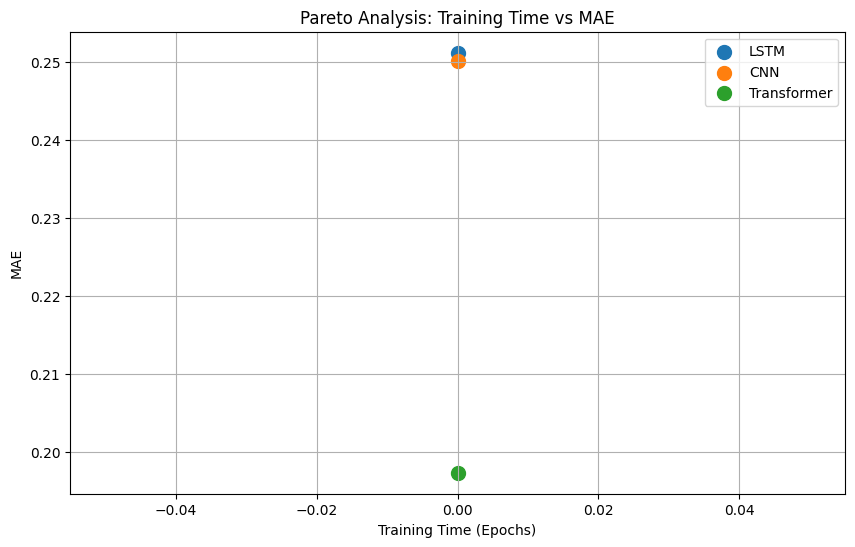

228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
228/228 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
228/228 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

Ensemble Model Evaluation:
Ensemble MAE: 0.0572
Ensemble RMSE: 0.0701
Ensemble R²: 0.8975


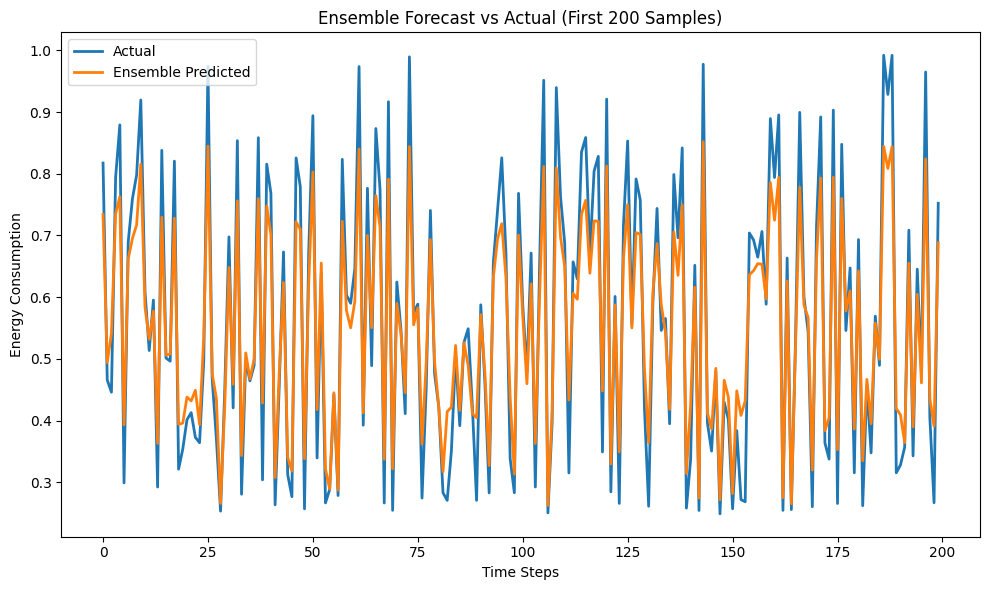

Best Model saved!
Results summary
Results in hyperband_results_fast/Transformer_forecasting
Showing 10 best trials
Objective(name="val_mae", direction="min")

Trial 0007 summary
Hyperparameters:
num_heads: 6
ff_dim: 32
dropout_rate: 0.30000000000000004
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/bracket: 1
tuner/round: 0
Score: 0.17388205230236053

Trial 0001 summary
Hyperparameters:
num_heads: 2
ff_dim: 64
dropout_rate: 0.2
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/bracket: 1
tuner/round: 0
Score: 0.1765715777873993

Trial 0011 summary
Hyperparameters:
num_heads: 6
ff_dim: 128
dropout_rate: 0.30000000000000004
tuner/epochs: 10
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.1868334263563156

Trial 0005 summary
Hyperparameters:
num_heads: 2
ff_dim: 96
dropout_rate: 0.30000000000000004
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/bracket: 1
tuner/round: 0
Score: 0.1879933923482895

Trial 0000 summary
Hyperparameters:
num_heads: 2
ff_dim: 96
dropout_rate: 0.4
tuner/ep

In [13]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from keras_tuner import Hyperband
from sklearn.metrics import mean_absolute_error, mean_squared_error
import json

# Path to saved Hyperband results
hyperband_dir = 'hyperband_results_fast/'

# Function to load Hyperband logs and extract epochs
def get_training_time_from_logs(model_name):
    log_dir = os.path.join(hyperband_dir, f"{model_name}_forecasting")

    # Check if the directory exists
    if not os.path.exists(log_dir):
        raise ValueError(f"Log directory for {model_name} not found at {log_dir}")

    # Find the best trial log file
    log_files = [f for f in os.listdir(log_dir) if f.endswith('json')]

    # Load the best trial json log file
    trial_log_path = os.path.join(log_dir, log_files[0])  # Assuming first trial log file
    with open(trial_log_path, 'r') as f:
        trial_data = json.load(f)

    # Extract the epoch and the final training time (last epoch)
    epochs = []
    for metric in trial_data.get('metrics', []):
        if 'epoch' in metric:
            epochs.append(metric['epoch'])

    # If epochs exist, take the last one as training time
    training_time = epochs[-1] if epochs else 0
    return training_time

# Common Callback
stop_early = EarlyStopping(monitor="val_loss", patience=3)

# Run Hyperband for each model
model_builders = {
    "LSTM": build_lstm_model,
    "CNN": build_cnn_model,
    "Transformer": build_transformer_model
}

best_models = {}
best_hps = {}
best_maes = {}
training_times = {}

for name, builder in model_builders.items():
    print(f"\nRunning Hyperband for {name} model...")

    tuner = Hyperband(
        builder,
        objective="val_mae",
        max_epochs=10,       # 10 epochs to test each model
        factor=5,            # factor of 5 for faster tuning
        directory="hyperband_results_fast",
        project_name=f"{name}_forecasting",
        executions_per_trial=1  # this stays inside Hyperband constructor
    )

    tuner.search(
        X_train, y_train,
        epochs=10,                          # each trial runs for 10 epochs
        validation_data=(X_val, y_val),
        callbacks=[stop_early],
        verbose=1                          # set verbose to see detailed logs
    )

    # Retrieve best model + hyperparameters
    best_models[name] = tuner.get_best_models(num_models=1)[0]
    best_hps[name] = tuner.get_best_hyperparameters(num_trials=1)[0]

    # Evaluate model
    y_pred = best_models[name].predict(X_val)
    mae = np.mean(np.abs(y_val - y_pred))
    best_maes[name] = mae

    print(f"{name} model best MAE: {mae:.4f}")
    print("Best hyperparameters:")
    for k, v in best_hps[name].values.items():
        print(f"  {k}: {v}")

    # Retrieve training time from saved logs
    training_time = get_training_time_from_logs(name)
    training_times[name] = training_time

# Pareto Analysis
# Store model performance and time for Pareto analysis
results = []
for name in best_models:
    model = best_models[name]
    training_time = training_times[name]  # Use the recorded training time
    results.append((name, best_maes[name], training_time))

# Convert results to a DataFrame for easy manipulation
pareto_df = pd.DataFrame(results, columns=["Model", "MAE", "Training Time"])
pareto_df["Efficiency"] = pareto_df["MAE"] / pareto_df["Training Time"]  # Efficiency metric

# Plot Pareto front: MAE vs Training Time
plt.figure(figsize=(10, 6))
for model in pareto_df["Model"]:
    subset = pareto_df[pareto_df["Model"] == model]
    plt.scatter(subset["Training Time"], subset["MAE"], label=model, s=100)
plt.xlabel("Training Time (Epochs)")
plt.ylabel("MAE")
plt.title("Pareto Analysis: Training Time vs MAE")
plt.legend()
plt.grid(True)
plt.show()

# Ensemble Modeling
# Create predictions using each model (LSTM, CNN, Transformer)
predictions = []
for name in best_models:
    model = best_models[name]
    y_pred = model.predict(X_val)
    predictions.append(y_pred)

# Average the predictions to create an ensemble model (simple averaging)
ensemble_predictions = np.mean(predictions, axis=0)

# Evaluate the ensemble model
ensemble_mae = mean_absolute_error(y_val, ensemble_predictions)
ensemble_rmse = np.sqrt(mean_squared_error(y_val, ensemble_predictions))

from sklearn.metrics import r2_score
ensemble_r2 = r2_score(y_val, ensemble_predictions)
print(f"\nEnsemble Model Evaluation:")
print(f"Ensemble MAE: {ensemble_mae:.4f}")
print(f"Ensemble RMSE: {ensemble_rmse:.4f}")
print(f"Ensemble R²: {ensemble_r2:.4f}")

# Plot ensemble vs Actuals
plt.figure(figsize=(10, 6))
plt.plot(y_val[:200], label="Actual", linewidth=2)
plt.plot(ensemble_predictions[:200], label="Ensemble Predicted", linewidth=2)
plt.title("Ensemble Forecast vs Actual (First 200 Samples)")
plt.xlabel("Time Steps")
plt.ylabel("Energy Consumption")
plt.legend()
plt.tight_layout()
plt.show()

# Save the Best Model
best_hb_model = best_models[best_model_name]
best_hb_model.save("best_hyperband_forecasting_model.keras")
print("Best Model saved!")

# Hyperband Summary
tuner.results_summary()


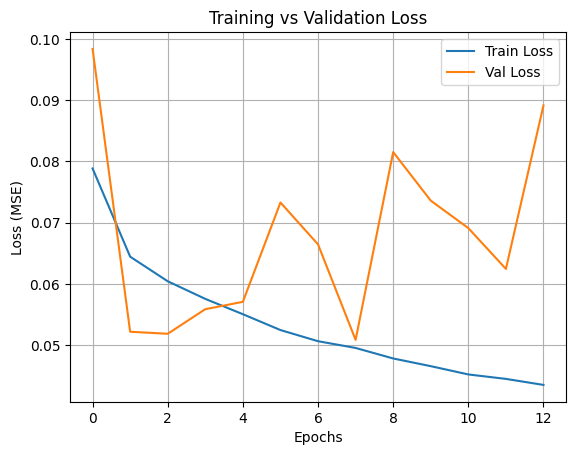

In [16]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss (MSE)")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

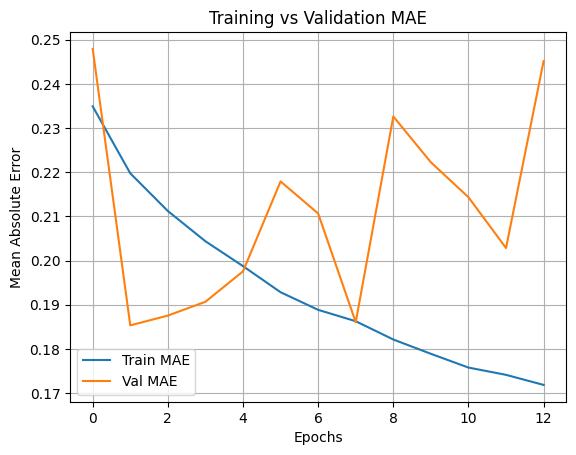

In [18]:
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Val MAE')
plt.xlabel("Epochs")
plt.ylabel("Mean Absolute Error")
plt.title("Training vs Validation MAE")
plt.legend()
plt.grid(True)
plt.show()

In [1]:
!pip install gradio -q
!pip install ipywidgets --quiet


[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: C:\Users\dhany\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: C:\Users\dhany\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [26]:
# Enable widgets
from google.colab import output
output.enable_custom_widget_manager()

# Imports
import keras_tuner as kt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from ipywidgets import interact_manual, IntSlider, Dropdown
from IPython.display import clear_output
import numpy as np

# Dummy dataset (replace with real data)
X = np.random.rand(500, 10, 1)  # [samples, timesteps, features]
y = np.random.rand(500, 1)

# Model builder
def build_model(hp, model_type):
    model = keras.Sequential()

    if model_type == "LSTM":
        model.add(layers.LSTM(
            units=hp.Int("units", min_value=32, max_value=128, step=32),
            input_shape=(X.shape[1], X.shape[2])
        ))

    elif model_type == "CNN":
        model.add(layers.Conv1D(
            filters=hp.Int("filters", 16, 64, step=16),
            kernel_size=3,
            activation="relu",
            input_shape=(X.shape[1], X.shape[2])
        ))
        model.add(layers.GlobalMaxPooling1D())

    elif model_type == "Transformer":
        # Simple Transformer block
        inputs = keras.Input(shape=(X.shape[1], X.shape[2]))
        x = layers.LayerNormalization()(inputs)
        attention = layers.MultiHeadAttention(
            num_heads=2,
            key_dim=hp.Int("transformer_dim", 16, 64, step=16)
        )(x, x)
        x = layers.Add()([x, attention])
        x = layers.GlobalAveragePooling1D()(x)
        outputs = layers.Dense(1)(x)
        model = keras.Model(inputs, outputs)
        model.compile(
            optimizer=keras.optimizers.Adam(
                hp.Choice("learning_rate", [1e-2, 1e-3, 1e-4])),
            loss="mse"
        )
        return model  # transformer model is returned early

    # For LSTM or CNN
    model.add(layers.Dense(1))
    model.compile(
        optimizer=keras.optimizers.Adam(
            hp.Choice("learning_rate", [1e-2, 1e-3, 1e-4])
        ),
        loss="mse"
    )
    return model

# UI function
def run_tuner_ui(model_type, max_epochs, factor, patience):
    clear_output(wait=True)

    print(f"Starting tuning for: {model_type}")
    print(f"Max Epochs: {max_epochs}, Factor: {factor}, Patience: {patience}")

    project_name = f"{model_type}_tuning"
    tuner_dir = "tuner_dir"

    tuner = kt.Hyperband(
        lambda hp: build_model(hp, model_type),
        objective="val_loss",
        max_epochs=max_epochs,
        factor=factor,
        directory=tuner_dir,
        project_name=project_name,
        overwrite=True
    )

    stop_early = keras.callbacks.EarlyStopping(monitor="val_loss", patience=patience)

    tuner.search(X, y, epochs=max_epochs, validation_split=0.2, callbacks=[stop_early])

    print("\nTuning completed!")

    best_hp = tuner.get_best_hyperparameters(1)[0]
    print("\nBest Hyperparameters:")
    for k, v in best_hp.values.items():
        print(f"   {k}: {v}")

    best_model = tuner.get_best_models(1)[0]
    print("\nBest Model Summary:")
    best_model.summary()

    save_path = f"/content/best_model_{model_type.lower()}.keras"
    best_model.save(save_path)
    print(f"\nBest model saved to: {save_path}")

# UI: Manual start with button
interact_manual(
    run_tuner_ui,
    model_type=Dropdown(
        options=["LSTM", "CNN", "Transformer"],
        description="Model:"
    ),
    max_epochs=IntSlider(min=5, max=30, step=5, value=10, description="Epochs:"),
    factor=IntSlider(min=2, max=5, step=1, value=3, description="Factor:"),
    patience=IntSlider(min=1, max=5, step=1, value=2, description="Patience:")
);

interactive(children=(Dropdown(description='Model:', options=('LSTM', 'CNN', 'Transformer'), value='LSTM'), In…